## Regression with dark matter halos

In this code, we will carry out a simple regression task. For this we will first download a public dark matter halo catalogue from the Bolshoi simulation. We will then use the Pandas library to analyse this halo catalogue and to identify correlation between different halo properties.
In the next step, we will use the Scikit-Learn library to predict the halo concentration from the other halo properties. For this we will test simple linear regression, a decision tree, and random forests. Finally, we will determine which regression algorithm performs best with respect to the test data set.

In [1]:
#Import modules
#Here we import all modules/libraries that are needed later. Don't worry for now.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

#Plot in cells
%matplotlib inline

### Loading the data
Now we need to load the dark matter halo catalogue. It can be found here:  
http://www.slac.stanford.edu/~behroozi/Bolshoi_Catalogs/  
The catalogue at z=0 is hlist_1.00035.list.gz.

In [2]:
#Load data from ascii file
data = np.genfromtxt("hlist_1.00035.list",comments='#',max_rows=10000)

In [4]:
#Define halo properties
#Each column gives us a different halo property. Here we define all those properties we want to use.
#If you feal like adding some more properties, try it out...
virial_mass   = np.log10(data[:,10])
virial_radius = np.log10(data[:,11])
concentration = np.log10(data[:,11] / data[:,12]) #Concentration is virial radius divided by scale length
velocity_disp = np.log10(data[:,13])
vmax          = np.log10(data[:,16])
spin          = np.log10(data[:,26])
b_to_a        = data[:,44]
c_to_a        = data[:,45]
energy_ratio  = data[:,54]
peak_mass     = np.log10(data[:,58])
peak_vmax     = np.log10(data[:,60])
halfmass_a    = data[:,61]
peakmass_a    = data[:,67]
acc_rate      = data[:,64]

#Create Pandas Data Frame
#For easier handling we use the Pandas library.
#The following lines load all halo properties into a Pandas data frame called halos.
#Add all halo properties here, after virial_mass:
halos = pd.DataFrame({
    'Virial Mass':virial_mass,
    'Virial Radius':virial_radius,
    'Concentration':concentration,
    'Velocity Disp':velocity_disp,
    'Vmax':vmax,
    'Spin':spin,
    'B to A':b_to_a,
    'C to A':c_to_a,
    'Energy ratio':energy_ratio,
    'Peak Mass':peak_mass,
    'peak Vmax':peak_vmax,
    'Halfmass a':halfmass_a,
    'Peakmass a':peakmass_a,
    'Acc Rate':acc_rate
})

In [7]:
halos['Vmax'][2]

2.9027750092993485

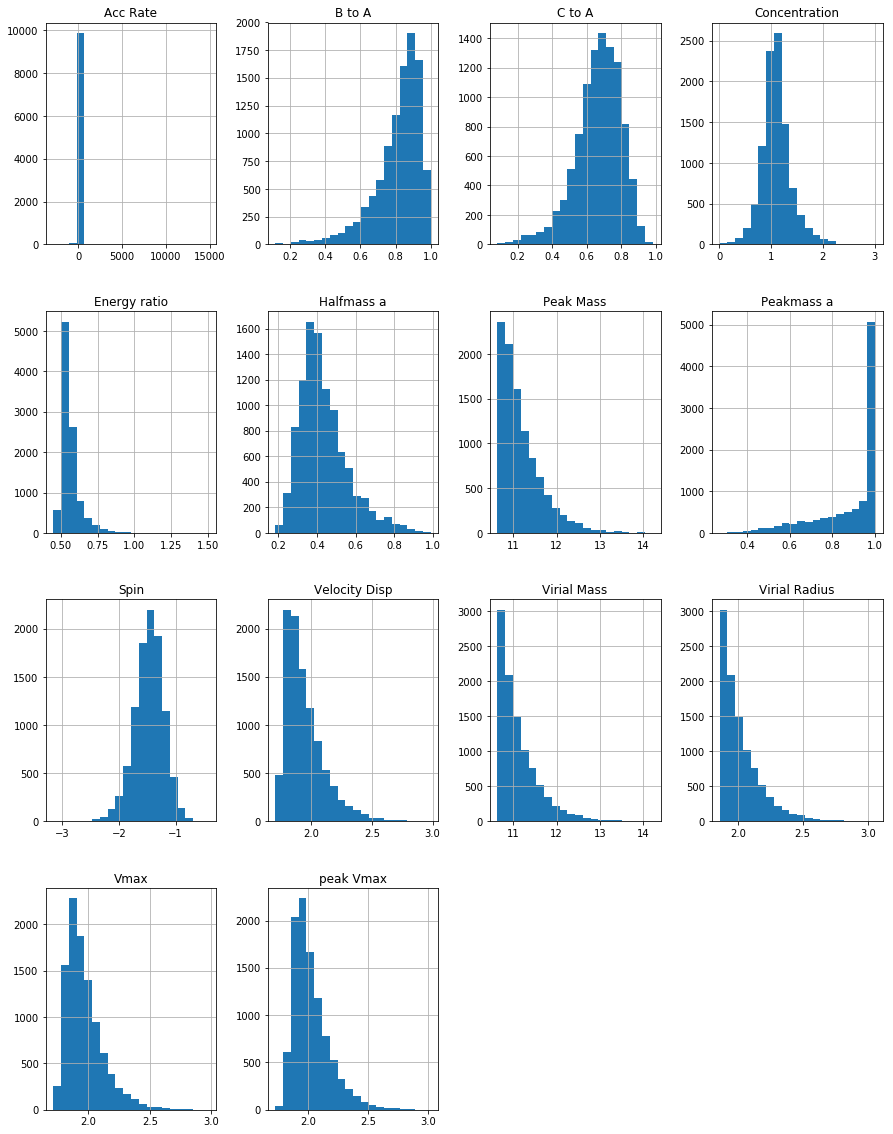

In [16]:
histograms = halos.hist(bins=20,figsize=[15,20])

#Plot a histogram for each halo property

#Use the function .hist that every pandas data frame has
#Something like 20 bins should work well

This plot shows a histogram for each halo property.
Since we are using machine learning, we will call the halo properties from now on 'features'.  
As we can see, some features, like the virial mass, the peak virial mass, and the virial radius start very high and then decline (they don't have a maximum). Some other features, like the half mass scale factor, the concentration, and the spin have a clear peak.

### Splitting the data into training and test sets

As is common in machine learning, we will want to test how well our solutions generalise to other data sets.
It doesn't help us, if the algorithm learned how to model a feature for our training set very well, if it completely fails when used with a different data set.  
For this we need to split our data set into a training and a test set. It is imporant that we split the data before we look at it any further, because our brains may already 'detect' some patterns, which is likely to result into overfitting. Looking at the test set, we might see an interesting pattern that leads us to choose a particular algorithm. But as soon as we want to generalise it, our system will not perform as well as expected. This is called *data snooping* bias.

In [17]:
#Split train and test set randomly
#We use 20 per cent of the total data set as test set
#Use train_test_split to split the data
#Use random_state= with some integer to always have the same random numbers
train, test = train_test_split(halos,test_size=0.2,random_state=23)

In [21]:
#Stratified split according to virial mass
#To be unbiased by the distribution of feature values, we can use stratified sampling.
#For this the split is not performed randomly, but sampled from subgroups (=strata) of a feature.
#Here we use the virial mass as a strata, and first define for each object, in which mass band it falls
cat_per_dex = 2.0 #This is the number of mass bands per dex of halo mass
mass_band = np.floor((virial_mass - virial_mass.min())*cat_per_dex)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=23)
for train_index, test_index in split.split(halos, mass_band):
    strat_train_set = halos.loc[train_index]
    strat_test_set = halos.loc[test_index]

### Correlations in the data
We want to predict the halo concentration from the other features. It is helpful to first get an idea how to do this, by looking at to correlations of each feature with the concentration. We leave the test set in peace and focus on the training set, which we call 'halos' again.

In [23]:
#Copy stratified training set to halos data frame
#Copy the training set to the halos data frame using the .copy() function
halos = strat_train_set.copy()

In [27]:
#Compute correlation matrix and show highest correlations for a given property
#The .corr() function gives you the correlation matrix
#You can then print the result with the ['Name of Feature'] subscript
#If you add .sort_values() the results will get sorted
corr_matrix = halos.corr()
print(corr_matrix['Concentration'].sort_values())

Halfmass a      -0.630659
Peakmass a      -0.509092
Spin            -0.310312
Energy ratio    -0.274113
Virial Mass     -0.233941
Virial Radius   -0.233940
Acc Rate        -0.102969
Peak Mass       -0.080611
Velocity Disp   -0.048208
Vmax             0.036712
peak Vmax        0.100407
B to A           0.425084
C to A           0.500384
Concentration    1.000000
Name: Concentration, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a125149e8>,
      dtype=object)

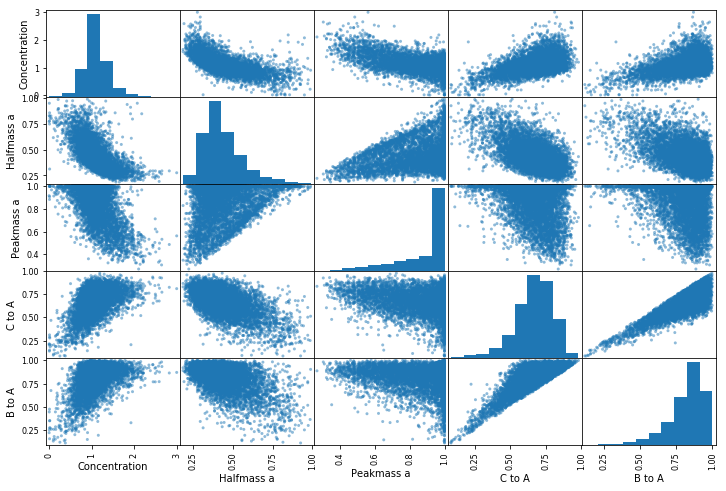

In [30]:
#Select most highly correlated features and show scatter plots
attributes=['Concentration','Halfmass a', 'Peakmass a', 'C to A', 'B to A']
pd.plotting.scatter_matrix(halos[attributes], figsize=(12,8))

It looks like concentration has the highest (anti-)correlation with Halfmass a, although the correlation with Peakmass a, C to A is also significant.  
Let's visualise this:

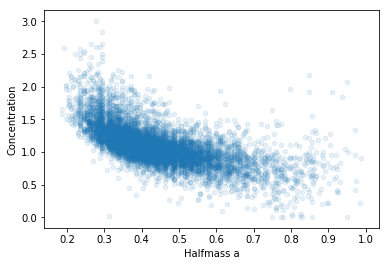

In [28]:
#Show scatter plot for highest correlation
halos.plot(kind='scatter', x='Halfmass a', y='Concentration', alpha=0.1)

### Preparing the data for machine learning
We first have to produce a set with the input features, i.e. all features except the concentraton, and a set for the labels (i.e. the target values). Then we prepare the data by defining pipelines that will scale the input features and take care of missing data.

In [31]:
#Select label for training and drop label from data set
halos_labels = strat_train_set['Concentration'].copy()
halos = strat_train_set.drop('Concentration', axis=1)

In [35]:
#Load an 'imputer' that fills missing data with median values of the remaining data set
imputer = Imputer(strategy='median')
imputer.fit(halos)
halos_tr = pd.DataFrame(imputer.transform(halos),columns=halos.columns)

In [36]:
#We cannot directly feed a Pandas data frame to scikit-learn.
#Therefore we need to difine a class that transforms our data fram into a numpy array.
#Define class to select a pandas data frame for sklearn input
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

Looking at the histograms above, there are some features that have a clear peak and therefore should be scaled with a standard scaller (i.e. the mean will be zero and the standard deviation one). Other features fall off monotonically, and hence are better scaled with min-maxing, i.e. the minimum will be zero and the maximum one. Some features are already scaled and hence need no rescaling.

In [45]:
#Define attributes for min-maxing
minmax_attribs = ['Virial Radius', 'Virial Mass', 'Peakmass a', 'Peak Mass']
#Define attributes for standard scaling
scaler_attribs = ['peak Vmax', 'Vmax', 'Spin', 'Halfmass a', 'Energy ratio', 'C to A', 'B to A']
#Set attributes that are left for no scaling
other_attribs  = list(halos)
for i in minmax_attribs: other_attribs.remove(i)
for i in scaler_attribs: other_attribs.remove(i)

In [60]:
#Set pipeline
#Here we define the pipelines for each attribute category (min-max, standard, other).

#Pipeline for min-maxing
minmax_pipeline = Pipeline([
    ('selector', DataFrameSelector(minmax_attribs)),
    ('imputer',  Imputer(strategy='median')),
    ('minmax',   MinMaxScaler())
    ])

#Pipeline for standard scaling
scaler_pipeline = Pipeline([
    ('selector', DataFrameSelector(scaler_attribs)),
    ('imputer',  Imputer(strategy='mean')),
    ('standard', StandardScaler())
    ])

#Pipeline for no scaling
#Note that no scaler has to be selected
other_pipeline = Pipeline([
    ('selector', DataFrameSelector(other_attribs)),
    ('imputer',  Imputer(strategy='median'))
    ])

#Combine Pipelines
#Add all three pipelines together
full_pipeline  = FeatureUnion(transformer_list=[
        ('minmax_pipeline', minmax_pipeline),
        ('scaler_pipeline', scaler_pipeline),
        ('other_pipeline', other_pipeline)
    ])

In [62]:
#Run halos through input pipeline to create scaled numpy array
halos_prepared = full_pipeline.fit_transform(halos)

### Training a linear regressor
Now that we have prepared the data, we can simply select a regressor and fit the data.

In [64]:
#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(halos_prepared,halos_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [65]:
#Compute Predictions and determine RMSE (=root mean squared error)
con_predictions = lin_reg.predict(halos_prepared)
lin_mse = mean_squared_error(halos_labels, con_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.08980533508048547

So we get a RMSE of about [0.0898]dex, i.e. about [?]%. For this little work, this is not too bad. Let's see how it looks like! For this we plot the predicted concentrations vs. the labels (i.e. the real concentrations).

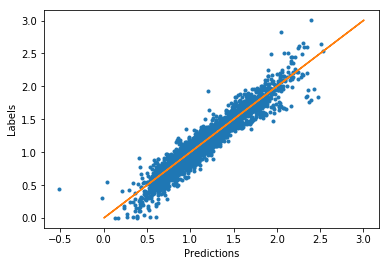

In [73]:
#Plot prediction vs label
#plt.axis([2,20,2,20])
plt.plot(con_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.xlabel('Predictions');
plt.ylabel('Labels');
#plot predicted concentration vs. labels
#plot the 'perfect' result

### Decesion Tree
Now, let's try a more complex model! A decision tree is a powerful model, capable of finding complex nonlinear relations in the data. In scikit-learn this is analogous to the linear regressor.

In [74]:
#Decision Tree
#Define the Regressor. Use DecisionTreeRegressor() here.
#Fit the regressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(halos_prepared,halos_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [76]:
#Compute Predictions and determine RMSE
con_predictions_tree = tree_reg.predict(halos_prepared)
tree_mse = mean_squared_error(halos_labels, con_predictions_tree)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

3.395332311069986e-05

Wow! That's quite some low error. How does it look like?

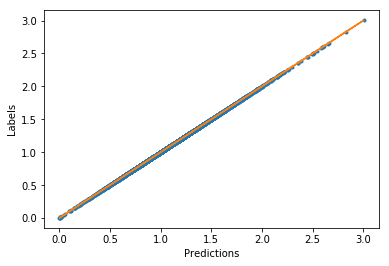

In [77]:
#Plot prediction vs label
plt.plot(con_predictions_tree, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.xlabel('Predictions');
plt.ylabel('Labels');

Hm... This almost looks too good to be true...  
Is it possible that we have overfitted? We better check! To do this, scikit-learn has a *cross-validation* method. For a K-fold cross-validation, the method randomly splits the (training) set into K distinct subsets called *folds*, then it trains and evaluates the regressor K times, picking a different fold for every evaluation every time and training on the other K-1 folds. This results in an array with K evaluation scores.

In [78]:
#Define function for validation output
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())

In [83]:
#Cross validate with cross_val_score() - insert the tree regressor, input and labels
#We us 10 folds, so cv=10
#The method expects a utility function (greater is better), so we need to use negative mean squared errors!
#For this use scoring="neg_mean_squared_error" inside cross_val_score
scores = cross_val_score(tree_reg,halos_prepared,halos_labels,cv=10,scoring="neg_mean_squared_error")
#Compute RMSE and display
tree_rmse_scores =  scores
display_scores(tree_rmse_scores)

Scores: [-0.03798304 -0.03795335 -0.03564639 -0.03033287 -0.03838558 -0.03770695
 -0.03861138 -0.04104854 -0.02915886 -0.04438662]
Mean: -0.037121358041833113
Standard Deviation: 0.004306546234373491


OK, yes, we have horribly overfitted! The mean RMSE is [?]dex, which means we are >[?]% off!  
Let's just quickly check our linear regressor with cross-validation:

In [84]:
#Cross validate linear regressor
lin_rmse_scores = cross_val_score(lin_reg,halos_prepared,halos_labels,cv=10,scoring="neg_mean_squared_error")
display_scores(lin_rmse_scores)

Scores: [-0.00755685 -0.00829966 -0.00733042 -0.00782221 -0.0086446  -0.00819058
 -0.008713   -0.00800159 -0.00730052 -0.00930656]
Mean: -0.008116600161249708
Standard Deviation: 0.0006153637847575719


Yes, indeed. The linear regressor did better. So a more complex method is not better when it overfits!

### Random Forests
Let's try one last model, Random Forests. They work by training many decision trees on random subsets of the features and then averaging out their predictions. We will deal with random forests in much greater detail, but for now let's just use them the same way as other scikit-learn regressors:

In [85]:
#Random Forests
#Define the Regressor. Use RandomForestRegressor() here.
#Fit the regressor
forest_reg = RandomForestRegressor()
forest_reg.fit(halos_prepared,halos_labels)

#forest_mse = mean_squared_error(halos_labels, con_predictions_forest)
#forest_rmse = np.sqrt(forest_mse)
#forest_rmse

0.06078528206406703

In [ ]:
#Compute Predictions and determine RMSE
con_predictions_forest = forest_reg.predict(halos_prepared)

In [86]:
#Cross validate
scores =  cross_val_score(forest_reg,halos_prepared,halos_labels,cv=10,scoring="neg_mean_squared_error")
forest_rmse_scores = scores 
display_scores(forest_rmse_scores)

Scores: [-0.01864385 -0.01890183 -0.01983448 -0.0169514  -0.02459388 -0.02184536
 -0.02110913 -0.02187245 -0.01803257 -0.02436877]
Mean: -0.020615370791412898
Standard Deviation: 0.002465399047660839


This is much better (though still not as good as linear regression). Also, note that the cross-validation score is worse than the score on the full training set, so we're still overfitting the data! Ways out here are either collecting more data, or constraining/regularizing the model. We will postpone that to later in the course...
How does the random forests result look like?

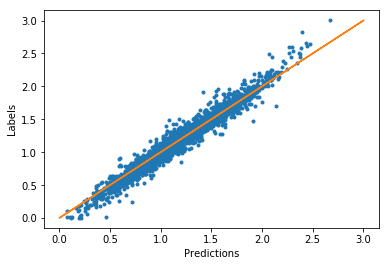

In [88]:
#Plot prediction vs label
plt.plot(con_predictions_forest, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.xlabel('Predictions');
plt.ylabel('Labels');

### Fine-tuning the model
Now, let's say we have a list of models that work well. We now need to fine-tune them and see which one works best. For this we have to understand how hyperparameters affect the results, and how we can select the best.  
We could fiddle with the hyperparameters manually, but this would be very tedious. Instead, scikit-learn's `GridSearchCV` can search the hyperparameter space. We just need to tell it which parameters to search, and it will evaluate all combinations with cross-validation.

In [90]:
#Perform hyperparameter grid search
#Here we first search 3x4=12 combinations of n_estimators and max_features.
#Then we set bootstrap to False and search 2x3=6 combinations.
#This training will take some time... Grab a coffee in the meanwhile...
param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2, 3, 4]},
]

#Use Random Forests
forest_reg = RandomForestRegressor()

#Define grid search and fit
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(halos_prepared, halos_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [94]:
#Show best hyperparameters
#They are stored in grid_search (use its best_params_ array)
grid_search.best_params_

{'max_features': 4, 'n_estimators': 30}

In [96]:
#Show best estimator
#They are stored in grid_search (use its best_estimator_ array)
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Now we can check how well the best estimator does.

In [97]:
#Compute Predictions and determine RMSE for best estimator
forest_reg = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
forest_reg.fit(halos_prepared,halos_labels)
con_predictions = forest_reg.predict(halos_prepared)

In [98]:
#Cross validate
scores =  cross_val_score(forest_reg,halos_prepared,halos_labels,cv=10,scoring="neg_mean_squared_error")
grid_rmse_scores = scores
display_scores(grid_rmse_scores)

Scores: [-0.0173985  -0.01755868 -0.0182076  -0.01526673 -0.0193281  -0.01772458
 -0.01912    -0.01785755 -0.01528344 -0.02087889]
Mean: -0.01786240951088193
Standard Deviation: 0.0016328868010282885


The RMSE has decreases a bit to [?]dex, so about [?] per cent. How does it look like?

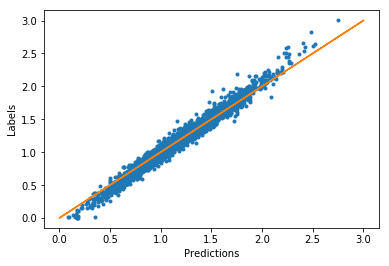

In [99]:
#Plot prediction vs label
plt.plot(con_predictions, halos_labels, '.');
plt.plot(halos_labels, halos_labels);
plt.xlabel('Predictions');
plt.ylabel('Labels');

### Final evaluation on the test set
Remember the test set we set aside for final evaluation? Now is the time to use it!  
For this we take our final model to be the best model the grid search has found, and run our test set through the preparation pipeline. We then compute the final prediction for the targets and meassure the final RMSE.

In [103]:
#Evaluate the system in the test set
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('Concentration', axis=1)
y_test = strat_test_set['Concentration'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

0.13186630377356276

Alright, [?]dex, just as we saw for the cross-validation (where we still used the training set). This performance is quite good, but not as good as the plots from the training set led us to believe.  
Here is the prediction vs. label for our final model using the test set:

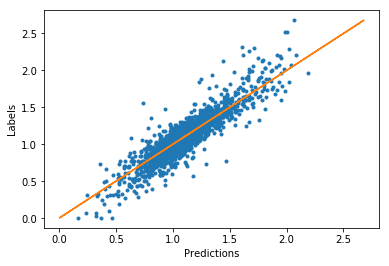

In [104]:
#Plot prediction vs label
plt.plot(final_predictions, y_test, '.');
plt.plot(y_test, y_test);
plt.xlabel('Predictions');
plt.ylabel('Labels');

We see that using the most complex model is not always necessarily the best solution, because the more complex a model is, the more prone to overfitting it is. In this case a simple linear regression model would have sufficied.  
However, there are techniques to prevent a more complex model from overfitting. We will have a look at these regularization methods later in the course.